# Exercises week 3 part 1: Implement a dense neural network

IN3310 / IN4310 - Machine Learning for Image Analysis

This exercise will walk you through the basics of PyTorch. The goal is for you to become familiar with:
- What is a computational graph
- How to define a pytorch data loader
- How to build a neural network in pytorch
- How to define a pytorch optimizer
- How to train a neural network in pytorch


We will assume the following software versions, but other versions may also work:
- Python 3.8 (at least 3.6 should also work)
- PyTorch 1.7.1


In addition to this exercise, we recommend you to have a look at the official tutorials on pytorch.org

https://pytorch.org/tutorials/index.html

## Play with MNIST Fashion and PyTorch

---
Your task is to use PyTorch to build a model and train a neural network on the MNIST Fashion dataset. Before you can start, you need to have access to the MNIST Fashion dataset. If you use an IFI computer, the default path given in this Jupyter Notebook file will root you to the data. If you work on any other computer, you will need to download the MNIST Fashion dataset. You can download the files from: https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion

MINST Fashion files:
- t10k-images-idx3-ubyte.gz
- t10k-labels-idx1-ubyte.gz
- train-images-idx3-ubyte.gz
- train-labels-idx1-ubyte.gz

Do not download the files with rightclick-save as in GitHub, but e.g. with left clicking and using the download button. If you get shape errors in the Dataset and your images files are only as few KBytes small, then you have not successfully downloaded the files.

The MNIST Fashion dataset have 10 classes: ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'].  

The training set consists of 60,000 images and the test set consists of 10,000 images. The images are of size [28,28].


**Important!**
You will need to add code only at locations where a NotImplementedError is raised.

<b>"%matplotlib inline"</b> is used to plot figures within Jupyter Notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.utility_functions import datasetFashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

---
### Step 1: Handling of the data

The following cell creates two instances of "datasetFashionMNIST". The "datasetFashionMNIST" is a "torch.utils.data.Dataset" written for the MNIST Fashion dataset.

If you do not use an IFI computer, edit the "dataPath" to the location of the MNIST Fashion dataset.


In [2]:
#Path to the MNIST Fashion files
dataPath = 'data/FashionMNIST/raw/'

# Create dataset objects
train_dataset = datasetFashionMNIST(dataPath=dataPath, train=True)
val_dataset   = datasetFashionMNIST(dataPath=dataPath, train=False)


data/FashionMNIST/raw/train-labels-idx1-ubyte.gz (60000,)
data/FashionMNIST/raw/train-images-idx3-ubyte.gz (47040000,)
data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz (10000,)
data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz (7840000,)


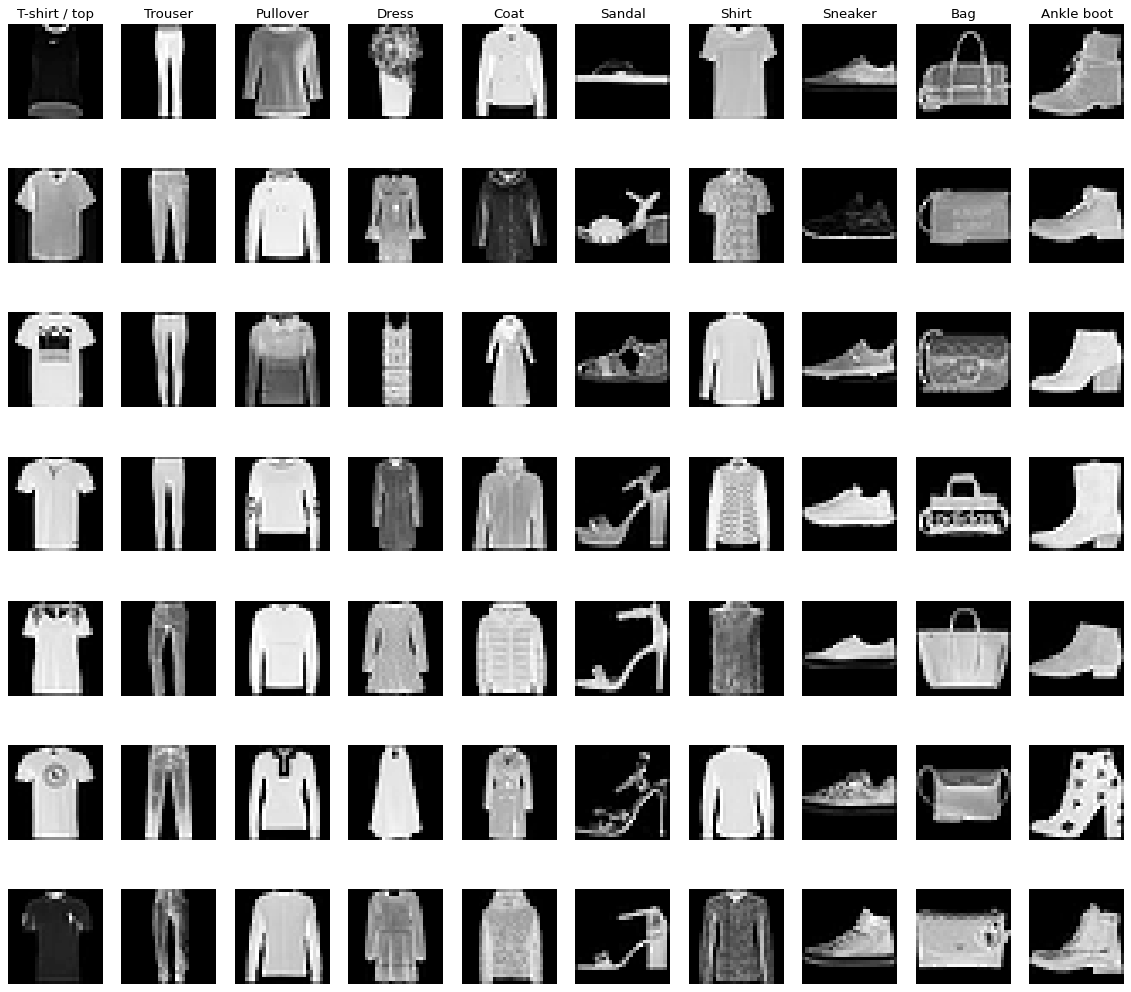

In [3]:
# Visualize some examples from the dataset.

# We show a few examples of training images from each class.
classes = ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(18, 16), dpi=80)
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.array(train_dataset.labels) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img = (train_dataset.images[idx,:]).astype(np.uint8)
        img = np.resize(img, (28, 28))   # reshape to 28x28
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

---
To keep track of important parameters, we use dictionary "config". When you are done implementing the NotImplementedError's below, you may find it interesting to experiment with different values for the batch size, learning rate and number of epochs trained. 

In [20]:
config = {
          'batch_size': 128,
          'use_cuda': False,      #True=use Nvidia GPU | False use CPU
          'log_interval': 20,     #How often to display (batch) loss during training
          'epochs': 20,           #Number of epochs
          'learning_rate': 0.001,
          'device': torch.device('cuda'),
          'momentum': 0.9
         }

We can iterate through the data with the instances of "datasetFashionMNIST". However, we will for convenience use PyTorch's "torch.utils.data.DataLoader" class as it helps us with batching and shuffling of the data. It also makes it possible to use multiple CPU cores/threads to speed up data preprocessing. Your task is to instantiate two data loaders (one for each of the training and validation dataset objects), using PyTorch's dataloader "torch.utils.data.DataLoader". Consider if you will use multiple workers and shuffling of data.

In [24]:
from torch.utils.data import DataLoader
import multiprocessing

cpu_count = multiprocessing.cpu_count()
num_workers = cpu_count // 2
print(f"Choose num_workers={num_workers}, since cpu_count={cpu_count}")

# DataLoaders
train_loader = DataLoader(train_dataset, config['batch_size'], shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, config['batch_size'], shuffle=True, num_workers=num_workers, pin_memory=True)


Choose num_workers=16, since cpu_count=32


---
### Step 2: Build the model

You are now to define the network architecture. The code provided below defines a fully connected neural network (dense neural network) with two hidden layer of size 128 and 64. However, we encourage you to play with the network configuration.

The input has shape [batch size, 28x28]. The 28x28 image size are being concatenated in "datasetFashionMNIST". Try to change:
- The number of layers
- The size of the hidden layers
- The activation functions


Note that the model inherits from "torch.nn.Module", which requires the two class methods "__init__" and "forward". The former defines the layers used by the model, while the latter defines how the layers are stacked inside the model.


In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
# Create an instance of Model
model = Model()
model.to(config['device'])

Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

---
### Step 3: Define optimizer and loss function

Instantiate an optimizer, e.g. stochastic gradient descent, from the "torch.optim" module (https://pytorch.org/docs/stable/optim.html) with your model. Remember that we have defined "learning rate" inside the config-dictionary.


In [21]:
# Create an instance of "torch.optim.SGD"

optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])

---
Here we want to define the loss function (often called criterion). As we are dealing with a classification problem, the softmax cross entropy loss is an appropriate choice.

Hint, have a look here: (https://pytorch.org/docs/stable/nn.html#torch-nn-functional)

In [22]:
def loss_fn(prediction, labels):
    """Returns softmax cross entropy loss."""
    loss_fn = nn.CrossEntropyLoss()
    return loss_fn(prediction, labels)

---
### Step 4: Set up the training process and train the model

You now have all the building blocks needed to set up the training process. You will implement the function "run_epoch" which shall loop though a dataset and train the model.


In [23]:
def run_epoch(model, epoch, data_loader, optimizer, is_training, config):
    """
    Args:
        model        (obj): The neural network model
        epoch        (int): The current epoch
        data_loader  (obj): A pytorch data loader "torch.utils.data.DataLoader"
        optimizer    (obj): A pytorch optimizer "torch.optim"
        is_training (bool): Whether to use train (update) the model/weights or not. 
        config      (dict): Configuration parameters

    Intermediate:
        totalLoss: (float): The accumulated loss from all batches. 
                            Hint: Should be a numpy scalar and not a pytorch scalar

    Returns:
        loss_avg         (float): The average loss of the dataset
        accuracy         (float): The average accuracy of the dataset
        confusion_matrix (float): A 10x10 matrix
    """
    
    if is_training==True: 
        model.train()
    else:
        model.eval()

    total_loss       = 0 
    correct          = 0 
    confusion_matrix = np.zeros(shape=(10,10))
    labels_list      = [0,1,2,3,4,5,6,7,8,9]

    for batch_idx, data_batch in enumerate(data_loader):
        images = data_batch[0].to(config['device']) # send data to GPU
        labels = data_batch[1].to(config['device']) # send data to GPU

        if not is_training:
            with torch.no_grad():
                prediction = model.forward(images)
                loss = loss_fn(prediction, labels)
                total_loss += loss.detach().cpu().numpy()
                
        elif is_training:
            optimizer.zero_grad()
            prediction = model.forward(images)
            loss = loss_fn(prediction, labels)
            total_loss += loss.detach().cpu().numpy()
            loss.backward()
            optimizer.step()
            
        # Update the number of correct classifications and the confusion matrix
        predicted_label  = prediction.max(1, keepdim=True)[1][:,0]
        correct          += predicted_label.eq(labels).cpu().sum().numpy()
        confusion_matrix += metrics.confusion_matrix(labels.cpu().numpy(), predicted_label.cpu().numpy(), labels=labels_list)

        # Print statistics
        #batchSize = len(labels)
        if batch_idx % config['log_interval'] == 0:
            print(f'Epoch={epoch} | {(batch_idx+1)/len(data_loader)*100:.2f}% | loss = {loss:.5f}')

    loss_avg         = total_loss / len(data_loader)
    accuracy         = correct / len(data_loader.dataset)
    confusion_matrix = confusion_matrix / len(data_loader.dataset)

    return loss_avg, accuracy, confusion_matrix


---
Here is where the action takes place!

In [25]:
# train the model
train_loss = np.zeros(shape=config['epochs'])
train_acc  = np.zeros(shape=config['epochs'])
val_loss   = np.zeros(shape=config['epochs'])
val_acc    = np.zeros(shape=config['epochs'])
train_confusion_matrix = np.zeros(shape=(10,10,config['epochs']))
val_confusion_matrix   = np.zeros(shape=(10,10,config['epochs']))

for epoch in range(config['epochs']):
    train_loss[epoch], train_acc[epoch], train_confusion_matrix[:,:,epoch] = \
                               run_epoch(model, epoch, train_loader, optimizer, is_training=True, config=config)

    val_loss[epoch], val_acc[epoch], val_confusion_matrix[:,:,epoch]     = \
                               run_epoch(model, epoch, val_loader, optimizer, is_training=False, config=config)

Epoch=0 | 0.21% | loss = 2.54214
Epoch=0 | 4.48% | loss = 2.14280
Epoch=0 | 8.74% | loss = 2.01649
Epoch=0 | 13.01% | loss = 1.76344
Epoch=0 | 17.27% | loss = 1.53918
Epoch=0 | 21.54% | loss = 1.46810
Epoch=0 | 25.80% | loss = 1.18374
Epoch=0 | 30.06% | loss = 1.18804
Epoch=0 | 34.33% | loss = 1.13639
Epoch=0 | 38.59% | loss = 1.09601
Epoch=0 | 42.86% | loss = 1.11078
Epoch=0 | 47.12% | loss = 1.09223
Epoch=0 | 51.39% | loss = 1.22596
Epoch=0 | 55.65% | loss = 0.74246
Epoch=0 | 59.91% | loss = 0.69744
Epoch=0 | 64.18% | loss = 0.69638
Epoch=0 | 68.44% | loss = 0.78365
Epoch=0 | 72.71% | loss = 0.74274
Epoch=0 | 76.97% | loss = 0.81161
Epoch=0 | 81.24% | loss = 0.80592
Epoch=0 | 85.50% | loss = 0.71406
Epoch=0 | 89.77% | loss = 0.74891
Epoch=0 | 94.03% | loss = 1.30336
Epoch=0 | 98.29% | loss = 0.66748
Epoch=0 | 1.27% | loss = 0.64709
Epoch=0 | 26.58% | loss = 0.65693
Epoch=0 | 51.90% | loss = 0.62929
Epoch=0 | 77.22% | loss = 0.63811
Epoch=1 | 0.21% | loss = 0.67600
Epoch=1 | 4.48% | l

---
### Step 5. Plot the train and validation losses
Plot the loss and the accuracy as a function of epochs to monitor the training.


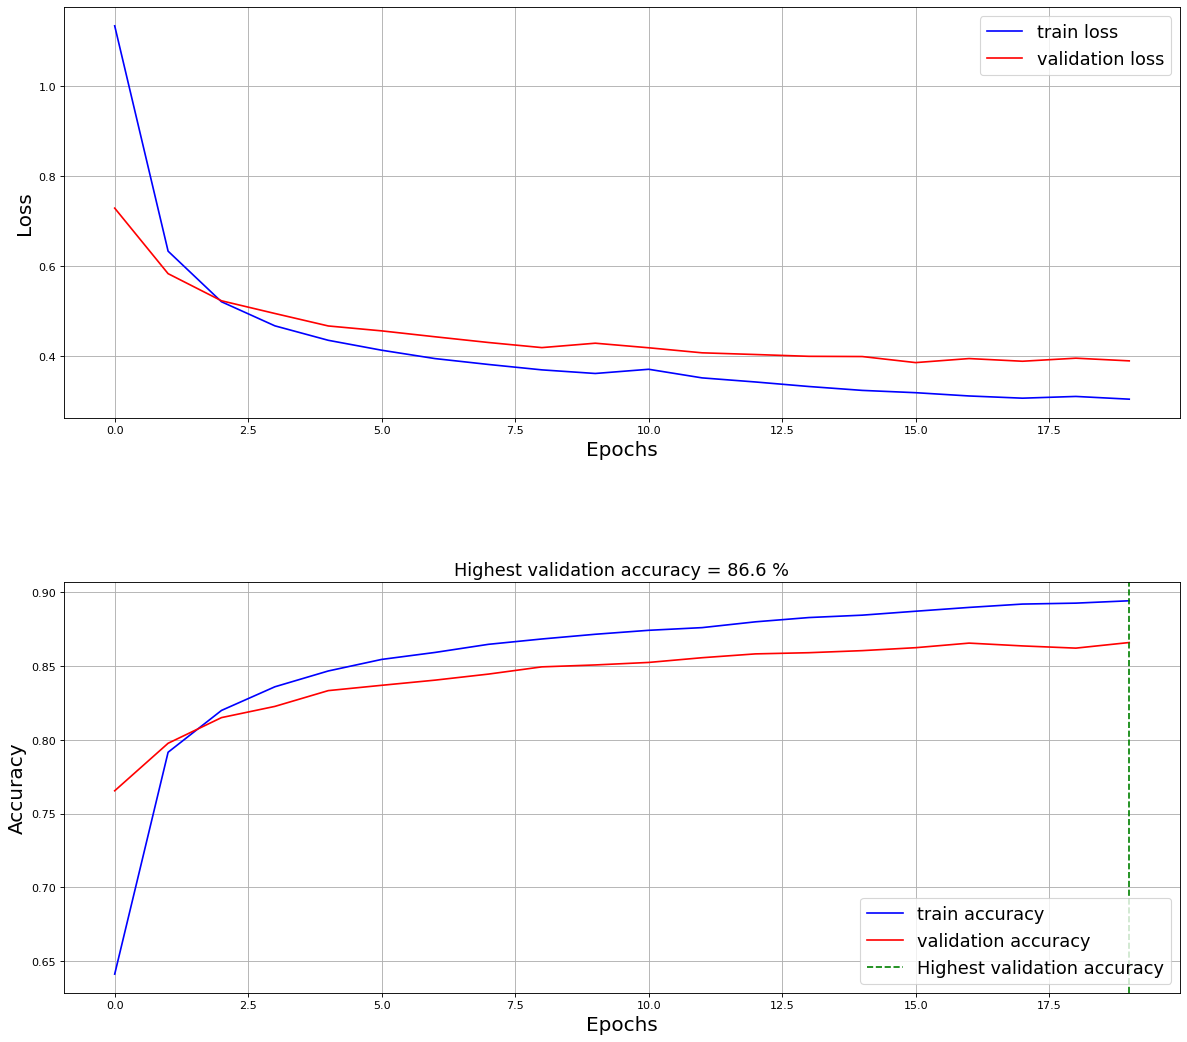

In [26]:
# Plot the loss and the accuracy in training and validation
#plt.figure()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, 'b', label='train loss')
ax.plot(val_loss, 'r', label='validation loss')
ax.grid()
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
ax.legend(loc='upper right', fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, 'b', label='train accuracy')
ax.plot(val_acc, 'r', label='validation accuracy')
ax.grid()
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)
plt.axvline(x=val_acc_max_ind, color='g', linestyle='--', label='Highest validation accuracy')
plt.title('Highest validation accuracy = %0.1f %%' % (val_acc_max*100), fontsize=16)
ax.legend(loc='lower right', fontsize=16)
plt.ion()

---
Let us study the accuracy per class on the validation dataset. We use the result from the epoch with highest validation accuracy.


In [27]:
ind = np.argmax(val_acc)
class_accuracy = val_confusion_matrix[:,:,ind]
for ii in range(len(classes)):
    acc = val_confusion_matrix[ii,ii,ind] / np.sum(val_confusion_matrix[ii,:,ind])
    print(f'Accuracy of {str(classes[ii]).ljust(15)}: {acc*100:.01f}%')

Accuracy of T-shirt / top  : 80.2%
Accuracy of Trouser        : 95.7%
Accuracy of Pullover       : 82.6%
Accuracy of Dress          : 89.4%
Accuracy of Coat           : 76.1%
Accuracy of Sandal         : 94.1%
Accuracy of Shirt          : 63.9%
Accuracy of Sneaker        : 95.6%
Accuracy of Bag            : 95.1%
Accuracy of Ankle boot     : 93.3%


---
In order to see how the network learns to distinguish the different classes as the training progresses, we can plot the confusion matrices after each second epoch as heatmaps.

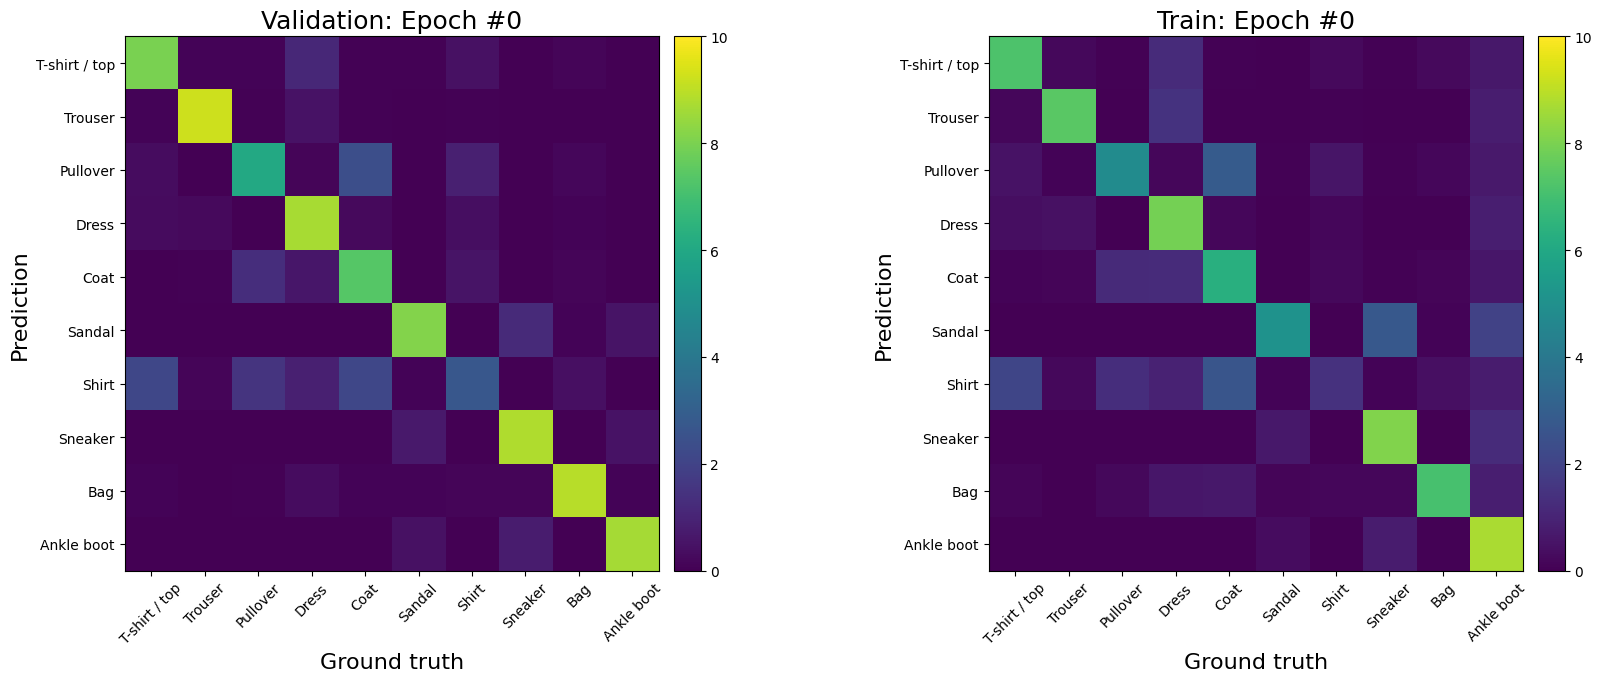

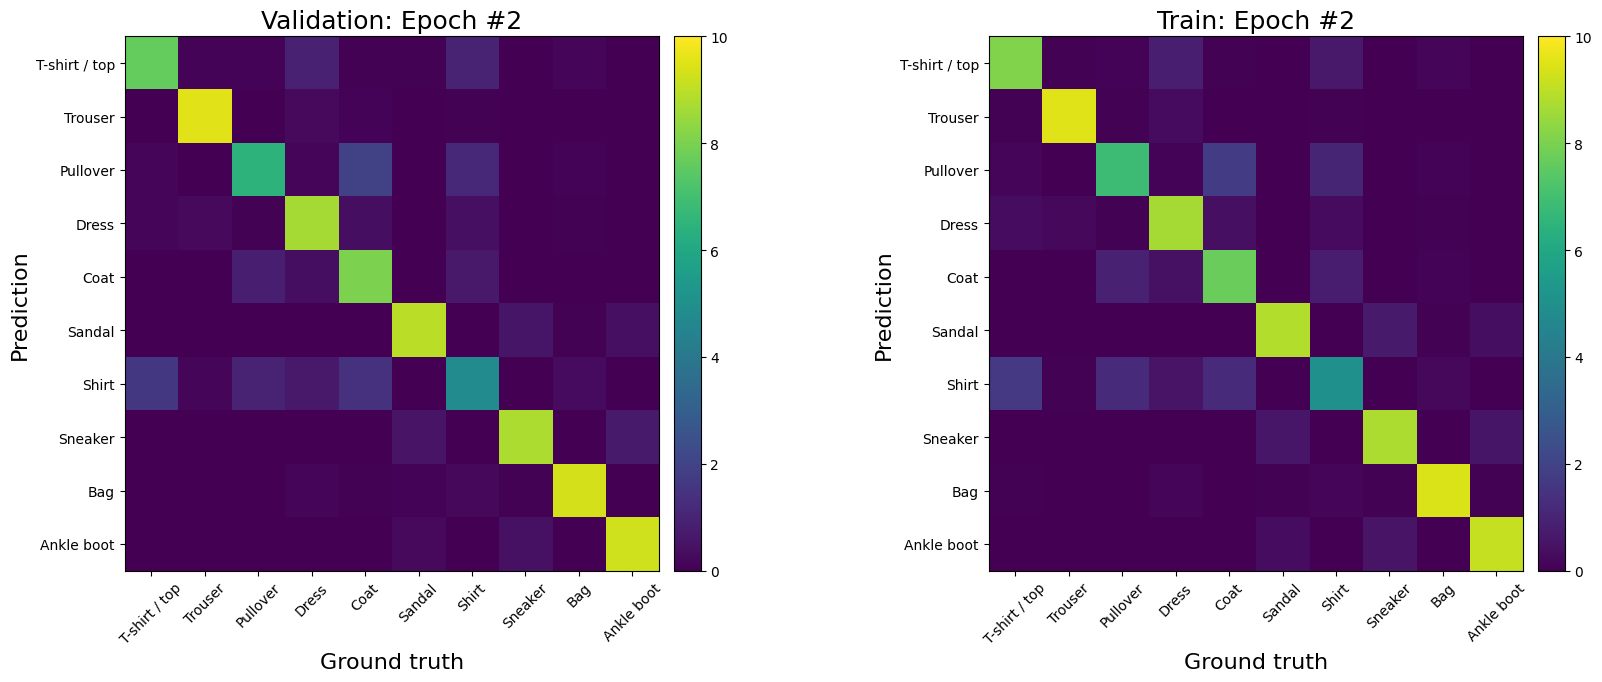

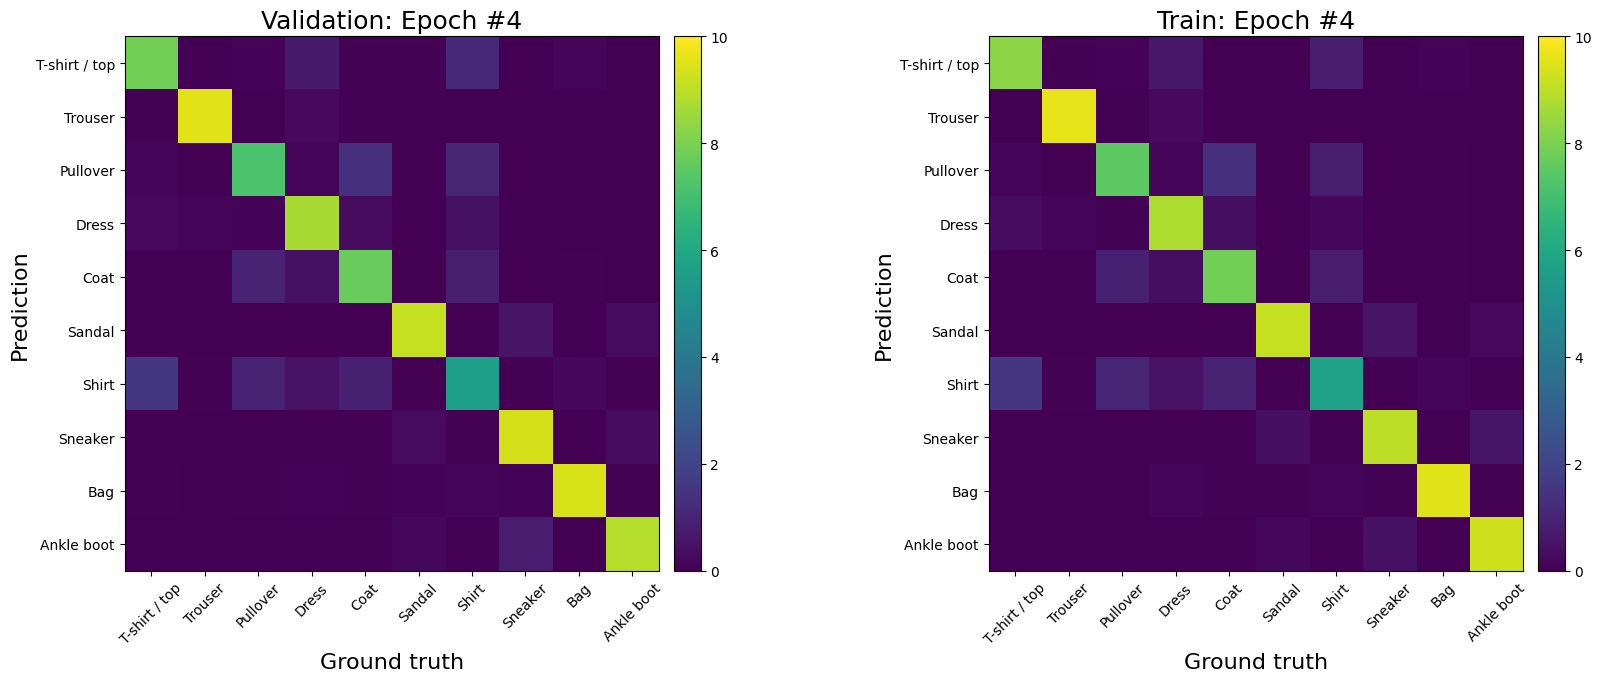

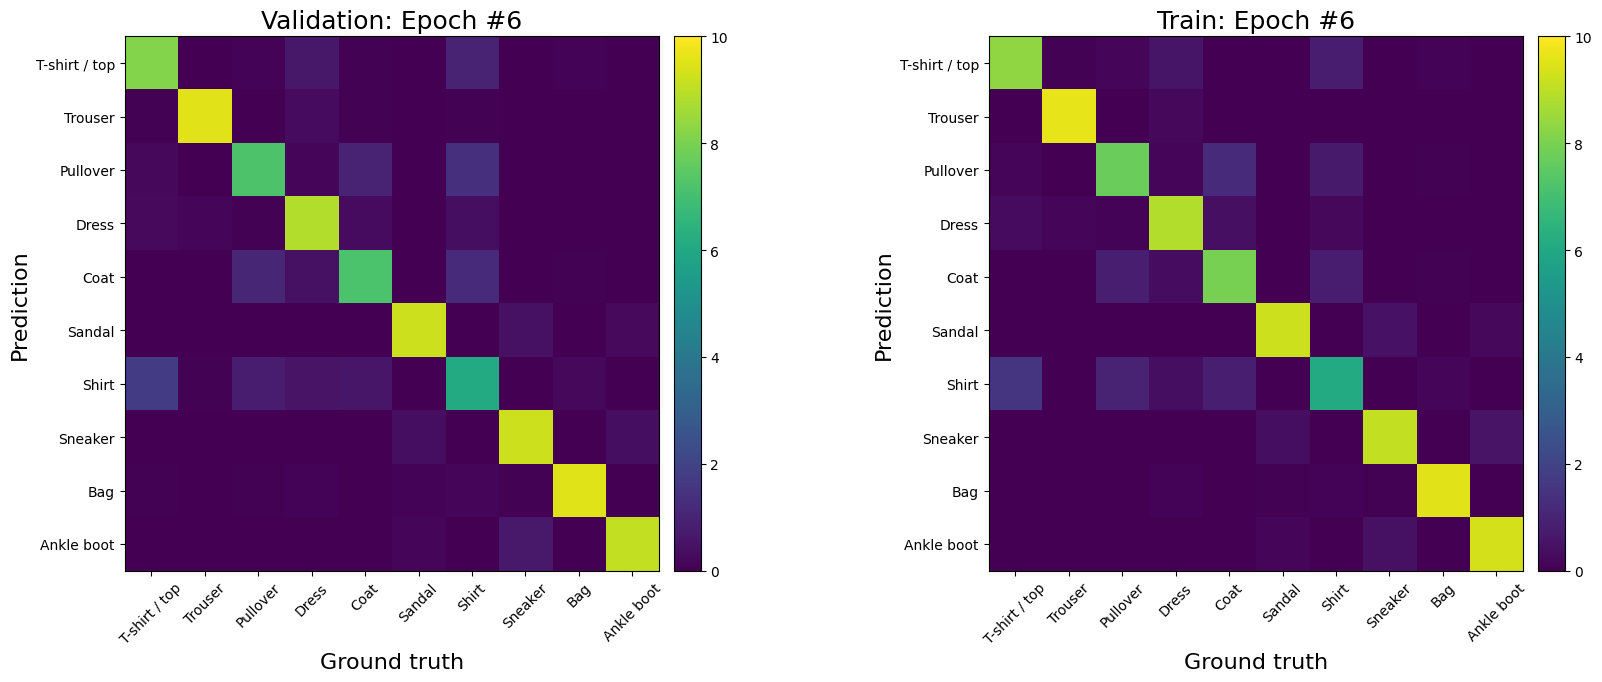

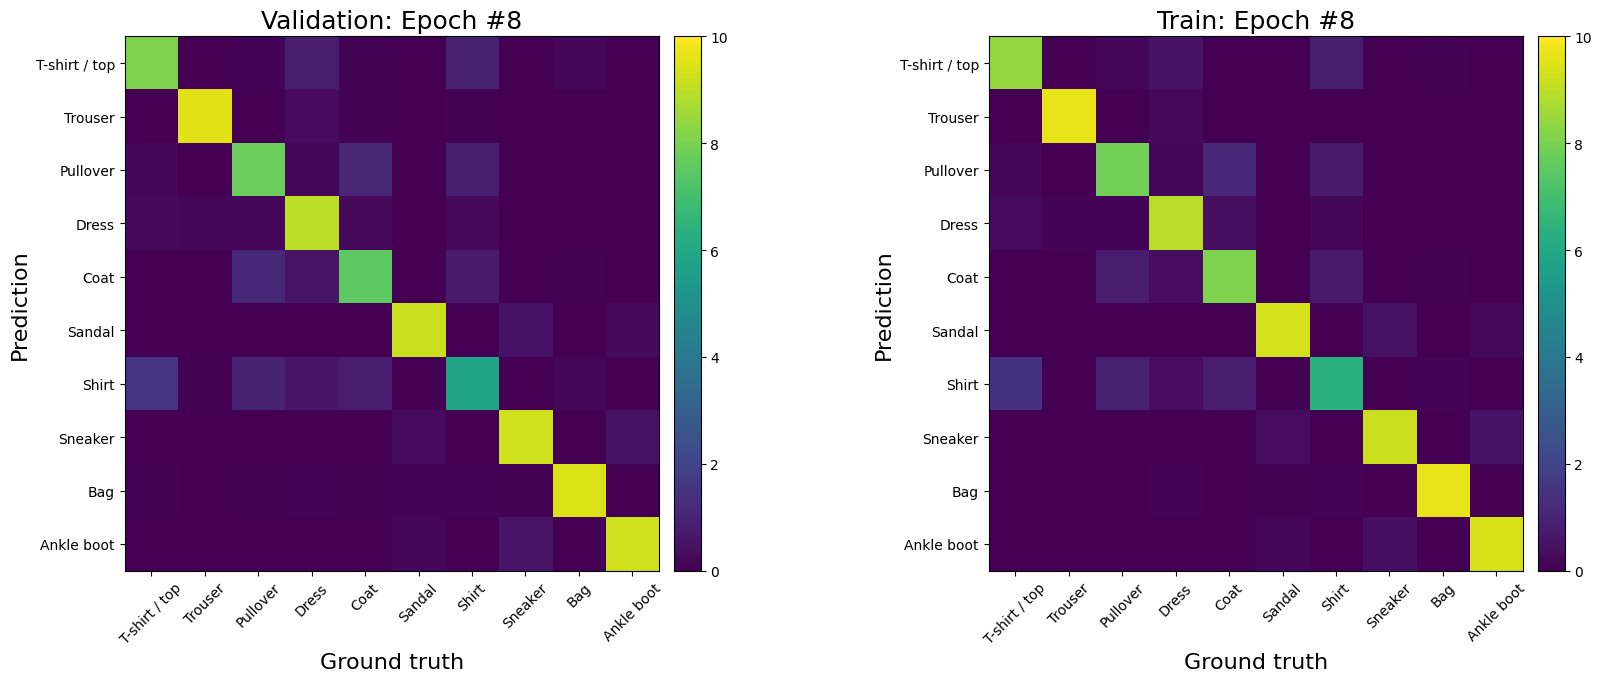

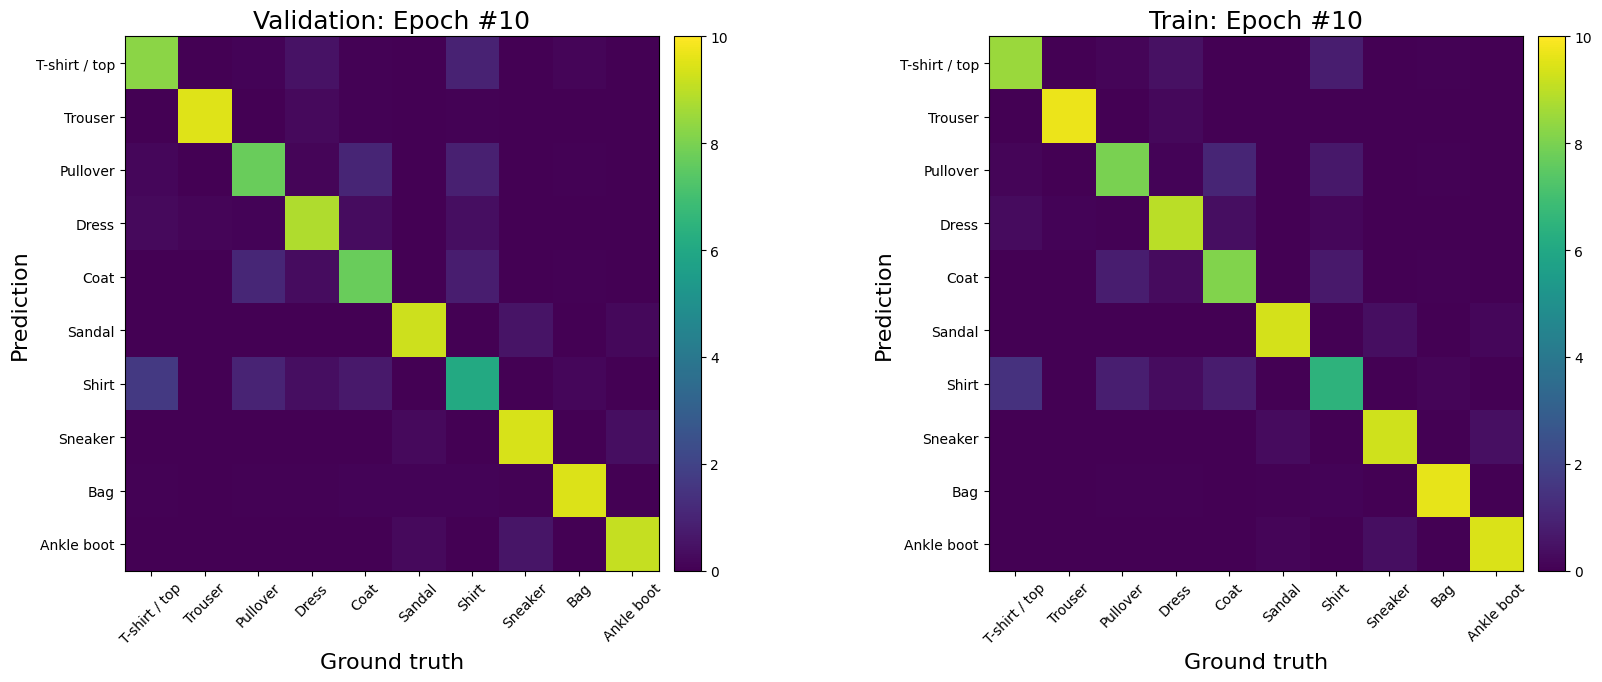

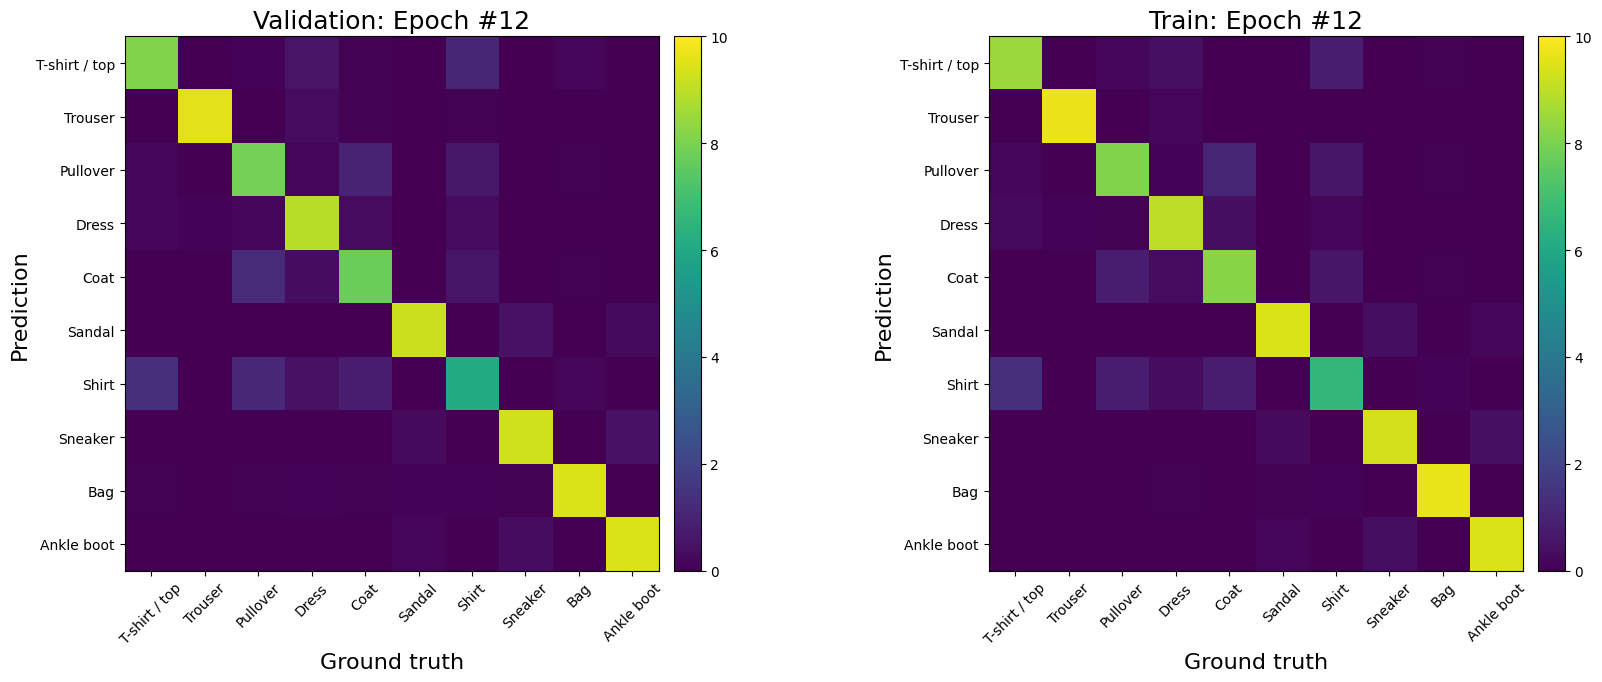

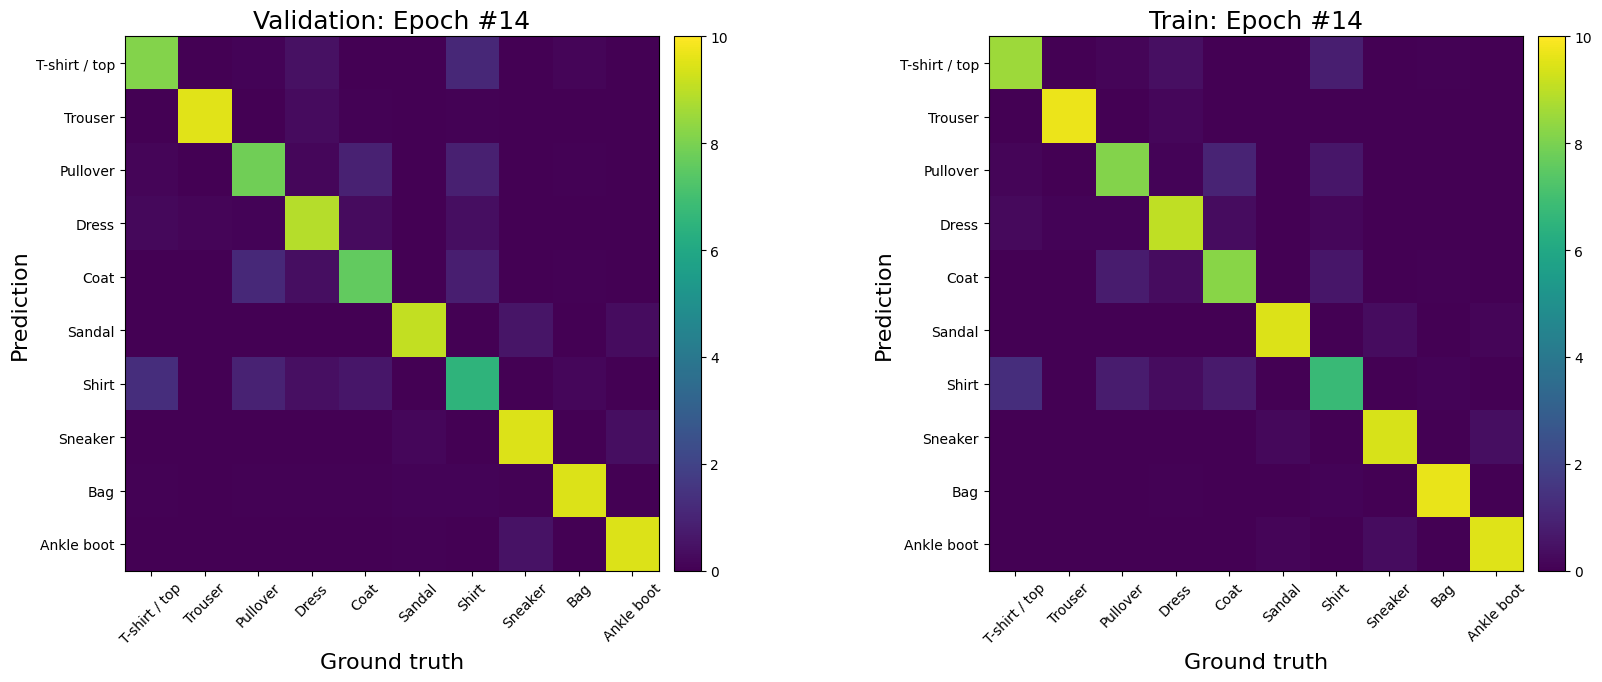

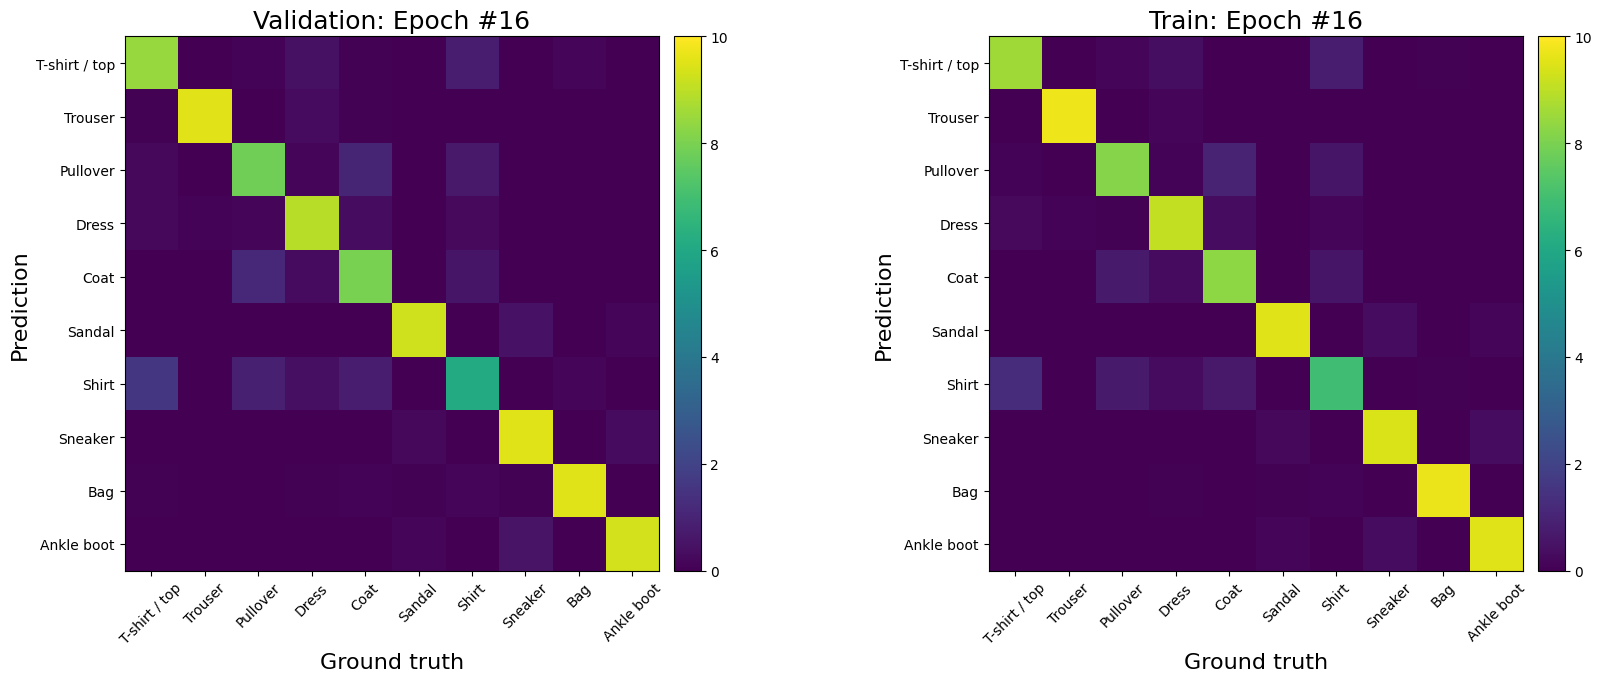

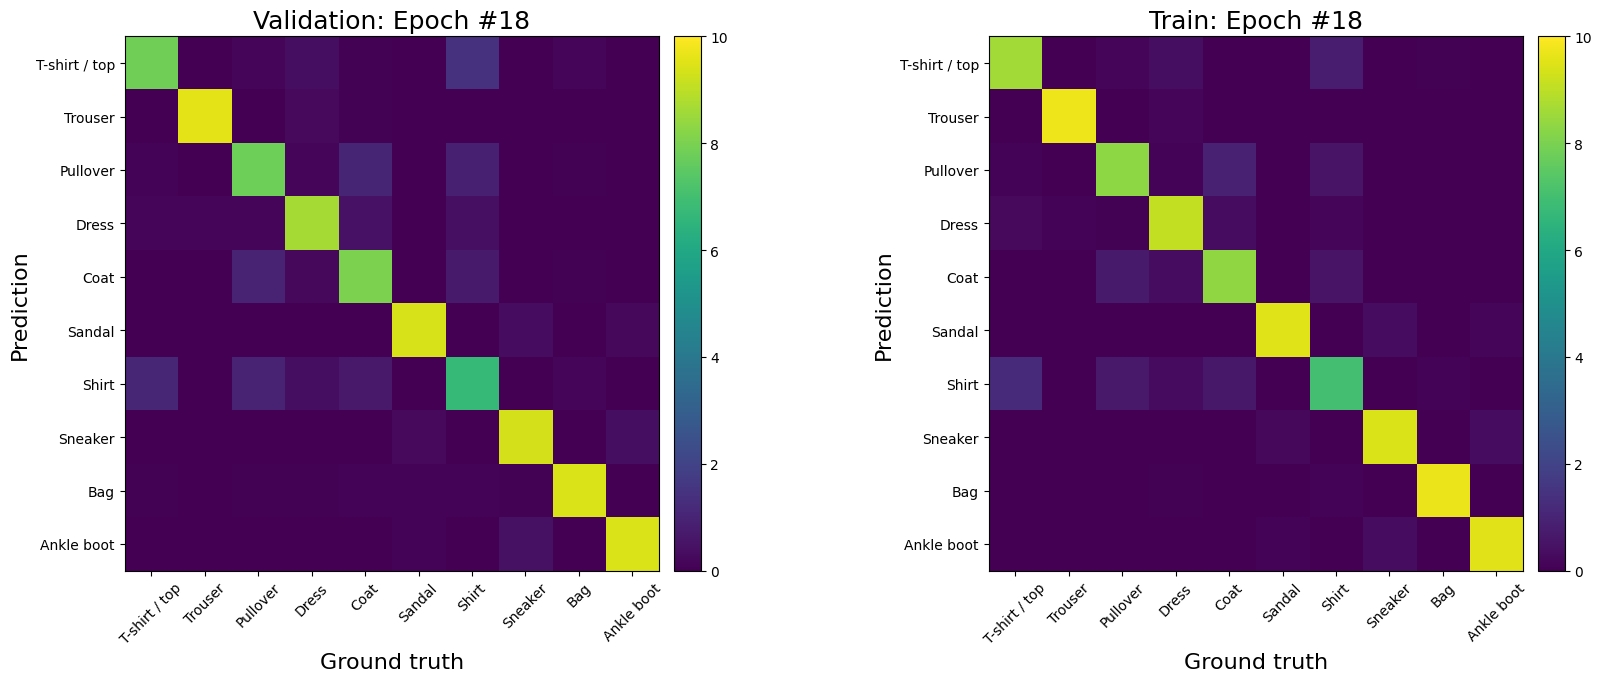

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epoch_step                  = 2    
set_colorbar_max_percentage = 10 
    
# Plot confusion matrices
ticks = np.linspace(0,9,10)
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.0, right=0.9, wspace=0.5, hspace=0.2)
for i in range(0, config['epochs'], epoch_step):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16), gridspec_kw=gridspec_kwargs)
    im = ax1.imshow(val_confusion_matrix[:, :, i]*100)
    ax1.set_title(f'Validation: Epoch #{i}', fontsize=18)
    ax1.set_xticks(ticks=ticks)
    ax1.set_yticks(ticks=ticks)
    ax1.set_yticklabels(classes)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_ylabel('Prediction', fontsize=16)
    ax1.set_xlabel('Ground truth', fontsize=16)
    divider = make_axes_locatable(ax1)
    cax     = divider.append_axes('right', size='5%', pad=0.15)
    f.colorbar(im, cax=cax, orientation='vertical')
    
    im = ax2.imshow(train_confusion_matrix[:, :, i]*100)
    ax2.set_title(f'Train: Epoch #{i}', fontsize=18)
    ax2.set_xticks(ticks=ticks)
    ax2.set_yticks(ticks=ticks)
    ax2.set_yticklabels(classes)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_ylabel('Prediction', fontsize=16)
    ax2.set_xlabel('Ground truth', fontsize=16)
    divider = make_axes_locatable(ax2)
    cax     = divider.append_axes('right', size='5%', pad=0.15)
    f.colorbar(im, cax=cax, orientation='vertical')    